In [1]:

import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

BALANCE_OFFSET = 128
BLOCK_SIZE = 8
BYTE_SIZE = 8


def visualize_dct_block_3d(dct_block):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = y = np.arange(0, 8, 1)
    X, Y = np.meshgrid(x, y)
    Z = dct_block

    ax.plot_surface(X, Y, Z)

    plt.show()

def visualize_np_array(data):
    # show data on each block
    plt.imshow(data, cmap='gray', vmin=-127, vmax=128)
    plt.colorbar()  # 显示颜色条

    # 在每个单元格上显示数字
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, data[i, j], ha='center', va='center', color='black')

    plt.show()

def set_lsb(block, bit):
    mask = 0x1F
    set_bit = bit * 0xF
    block[0][0] = np.float32(int(block[0][0]) & ~mask | set_bit)

def read_lsb(block):
    if block[0][0] > 0:
        ret = int((block[0][0] + 7) / 16) & 1
    else:
        ret = int((block[0][0] - 7) / 16) & 1
    return ret

def embed_message(image, input_bytes, set_method=set_lsb, **args):
    # Check if image is large enough to hide message
    height, width = image.shape[:2]
    if (width * height) / BLOCK_SIZE**2 < len(input_bytes):
        print("Error: Message too large to encode in image")
        return False

    # Pad image to be multiple of BLOCK_SIZE
    image = (
        cv2.resize(image, (width + (BLOCK_SIZE - width % BLOCK_SIZE), height + (BLOCK_SIZE - height % BLOCK_SIZE)))
        if height % 8 or width % 8
        else image
    )
    height, width = image.shape[:2]

    # Split image into HSV channels
    Yluma, Cr, Cb = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))
    edit_ch = np.float32(Yluma)

    # Blocks are 8x8 pixel chunks of the image
    blocks = [
        edit_ch[j : j + BLOCK_SIZE, i : i + BLOCK_SIZE] - BALANCE_OFFSET
        for j in range(0, height, BLOCK_SIZE)
        for i in range(0, width, BLOCK_SIZE)
    ]

    dct_blocks = [np.round(cv2.dct(block)) for block in blocks]
    # Embed message in image
    message_bits = "".join([format(char, "08b") for char in input_bytes])

    for index, block in enumerate(dct_blocks):
        if index == len(message_bits):
            break
        set_method(block, int(message_bits[index]), **args)

    # Inverse DCT
    ret_blocks = [cv2.idct(block) + BALANCE_OFFSET for block in dct_blocks]
    block_height, block_width = height // BLOCK_SIZE, width // BLOCK_SIZE
    blocks_2d = [
        ret_blocks[i * block_width : (i + 1) * block_width] for i in range(block_height)
    ]

    ret_image = np.block(blocks_2d)
    ret_image = np.uint8(ret_image)
    
    return cv2.merge((ret_image, Cr, Cb))

def extract_message(image, max_length=20, read_method=read_lsb, **args):
    height, width = image.shape[:2]
    Yluma, Cr, Cb = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))
    edit_ch = np.float32(Yluma)
    
    # Break down to blocks
    blocks = [
        edit_ch[j : j + BLOCK_SIZE, i : i + BLOCK_SIZE] - BALANCE_OFFSET
        for j in range(0, height, BLOCK_SIZE)
        for i in range(0, width, BLOCK_SIZE)
    ]
    
    dct_blocks = [np.round(cv2.dct(block)) for block in blocks]
    # the blocks are run through quantization table
    message = ''
    # message is extracted from LSB of DCT coefficients
    for index, block in enumerate(dct_blocks):
        if index == max_length * BYTE_SIZE:
            break

        bit = read_method(block, **args)
        message += str(bit)

    return int(message, 2).to_bytes(max_length, 'big')


In [2]:

# 示例用法
image = cv2.imread("lenna.png", cv2.IMREAD_UNCHANGED)
input_bytes = b"Hello, World!aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"

embed_image = embed_message(image, input_bytes)
cv2.imwrite("lenna_embed.jpg", cv2.cvtColor(embed_image, cv2.COLOR_YCrCb2BGR))

# plt.imshow(cv2.cvtColor(embed_image, cv2.COLOR_YCrCb2RGB))

extract_image = cv2.imread("lenna_embed.jpg", cv2.IMREAD_UNCHANGED)
extracted_message = extract_message(extract_image)
print(bytes(extracted_message))

b'Hello, World!aaaaaaa'


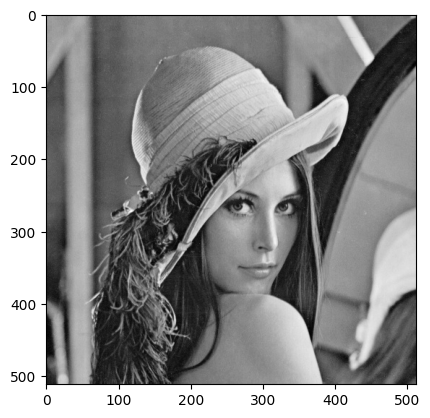

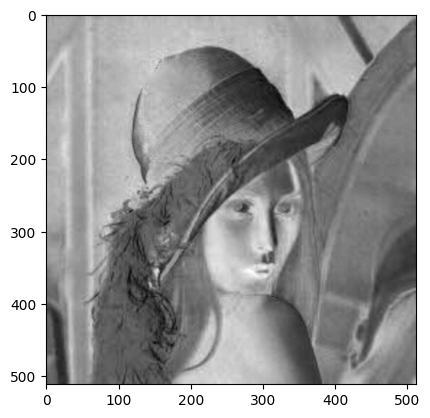

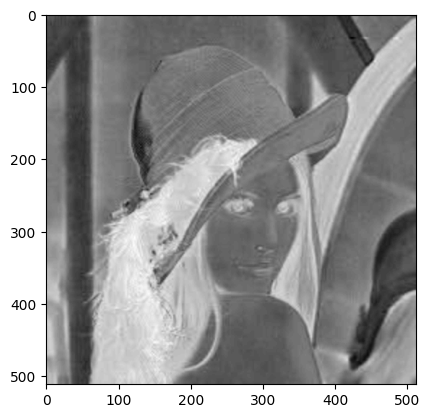

In [3]:
image = cv2.imread("lenna_embed.jpg", cv2.IMREAD_UNCHANGED)
ch1, ch2, ch3 =  cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb))

plt.imshow(ch1, cmap='gray')
plt.show()
plt.imshow(ch2, cmap='gray')
plt.show()
plt.imshow(ch3, cmap='gray')
plt.show()


In [4]:

JPEG_BRIGHTNESS_QUANTIZATION_TABLE = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

ZIGZAG_COORDINATE = np.array([
    [0, 1, 5, 6, 14, 15, 27, 28],
    [2, 4, 7, 13, 16, 26, 29, 42],
    [3, 8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]
])

ZIGZAG_TRAVERSE_ORDER = [0, 1, 8, 16, 9, 2, 3, 10, 17, 24, 32, 25, 18, 11, 4, 5, 12, 19, 26, 33, 40, 48, 41, 34, 27, 20, 13, 6, 7, 14, 21, 28, 35, 42, 49, 56, 57, 50, 43, 36, 29, 22, 15, 23, 30, 37, 44, 51, 58, 59, 52, 45, 38, 31, 39, 46, 53, 60, 61, 54, 47, 55, 62, 63]
COEFF_RANGE = 4
import random
# Find the nearest value in a numpy array return the index
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

# Find a group of values in a numpy array return the index
def find_nearest_group(array, value, cnt):
    idx = np.abs(array - value).flatten().argsort()[:cnt]
    return [np.unravel_index(i, array.shape) for i in idx]

def get_value_from_index(array, index):
    ordinate = np.unravel_index(index, array.shape)
    return array[ordinate]

def ind2ord(array, index):
    return np.unravel_index(index, array.shape)


dct_index_list = []
def set_bit(block, bit, alpha=50):
    ref_value = get_value_from_index(JPEG_BRIGHTNESS_QUANTIZATION_TABLE, random.choice(ZIGZAG_TRAVERSE_ORDER[1:COEFF_RANGE]))
    set_index = find_nearest_group(JPEG_BRIGHTNESS_QUANTIZATION_TABLE, ref_value, 2)

    global first_flag
    if first_flag:
        visualize_np_array(block)
        first_flag = False

    # Enhance the difference between the two values by alpha
    # If the first value is smaller than the second value, decrease the first value and increase the second value
    # If the first value is larger than the second value, increase the first value and decrease the second value
    # block[set_index[0]] < block[set_index[1]] means bit = 1
    # block[set_index[0]] > block[set_index[1]] means bit = 0
    if bit == 0:
        block[set_index[0]] = block[set_index[1]] + alpha
    if bit == 1:
        block[set_index[1]] = block[set_index[0]] + alpha

    difference = abs(block[set_index[0]] - block[set_index[1]])
    if difference < alpha:
        if block[set_index[0]] < block[set_index[1]]:
            block[set_index[0]] -= abs(alpha - difference) / 2
            block[set_index[1]] += abs(alpha - difference) / 2
        else:
            block[set_index[0]] += abs(alpha - difference) / 2
            block[set_index[1]] -= abs(alpha - difference) / 2

    dct_index_list.append(bit)

    # assert abs(block[set_index[0]] - block[set_index[1]]) >= alpha
    # assert (block[set_index[0]] < block[set_index[1]] and bit == 1) or (block[set_index[0]] > block[set_index[1]] and bit == 0)

read_index_list = []
def read_bit(block):
    
    global first_flag
    if first_flag:
        visualize_np_array(block)
        first_flag = False
    
    ref_value = get_value_from_index(JPEG_BRIGHTNESS_QUANTIZATION_TABLE, random.choice(ZIGZAG_TRAVERSE_ORDER[1:COEFF_RANGE]))
    set_index = find_nearest_group(JPEG_BRIGHTNESS_QUANTIZATION_TABLE, ref_value, 2)
    result = 1 if block[set_index[0]] < block[set_index[1]] else 0

    read_index_list.append(result)
    return result

key = 0xDEAD
message = b"hello, zenor0"

image = cv2.imread("lenna.jpg", cv2.IMREAD_UNCHANGED)

first_flag = True
random.seed(key)
embed_image = embed_message(image, message, set_method=set_bit, alpha=20)


cv2.imwrite("lenna_embed.jpg", cv2.cvtColor(embed_image, cv2.COLOR_YCrCb2BGR))

first_flag = True
random.seed(key)
embed_image = cv2.imread("lenna_embed.jpg", cv2.IMREAD_UNCHANGED)
show_image(embed_image)
msg = extract_message(embed_image, read_method=read_bit, max_length=len(message))

print(msg)

message_bits = "".join([format(char, "08b") for char in input_bytes])
print('message  ', [int(bit) for bit in message_bits])
print('extracted', read_index_list)

[ WARN:0@0.866] global loadsave.cpp:248 findDecoder imread_('lenna.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

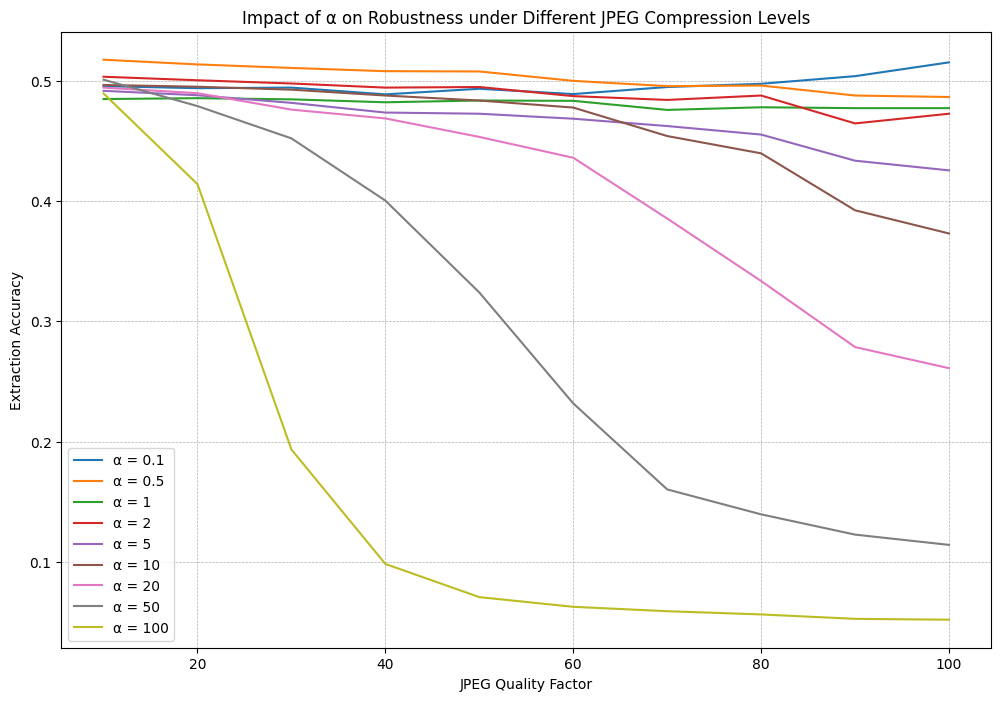

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

key = 0xDEAD
# 生成实验图像
image = cv2.imread('lenna.png', cv2.IMREAD_UNCHANGED)
h, w = image.shape[:2]
alpha_values = [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100]
quality_factors = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
results = {alpha: [] for alpha in alpha_values}

# 信息嵌入和提取实验
for alpha in alpha_values:
    embedded_image = np.copy(image)
    info_bits = np.random.randint(0, 2, size=(h // 8, w // 8))
    info_str = ''.join(str(bit) for bit in info_bits.flatten())
    info_bytes = int(info_str, 2).to_bytes(len(info_str) // 8, 'big')
    # info_bytes = b'bbbbbbbbb'
    # print(info_bytes)
    
    random.seed(key)
    img = embed_message(image, info_bytes, set_method=set_bit, alpha=alpha)
    
    for qf in quality_factors:
        encoded_image = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), qf])[1]
        decoded_image = cv2.imdecode(encoded_image, cv2.IMREAD_UNCHANGED)
        
        random.seed(key)
        extracted_bytes = extract_message(decoded_image, read_method=read_bit, max_length=len(info_bytes))
        extracted_bits = np.unpackbits(np.frombuffer(extracted_bytes, dtype=np.uint8))

        accuracy = 1 - np.mean(info_bits.flatten() == extracted_bits)
        results[alpha].append((qf, accuracy))

# 可视化结果
plt.figure(figsize=(12, 8))
for alpha in alpha_values:
    qfs, accuracies = zip(*results[alpha])
    plt.plot(qfs, accuracies, label=f'α = {alpha}')

plt.xlabel('JPEG Quality Factor')
plt.ylabel('Extraction Accuracy')
plt.title('Impact of α on Robustness under Different JPEG Compression Levels')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



In [ ]:
# results to csv 
import csv
import os

with open('results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Alpha'] + quality_factors)
    for alpha in alpha_values:
        row = [alpha] + [accuracy for qf, accuracy in results[alpha]]
        writer.writerow(row)

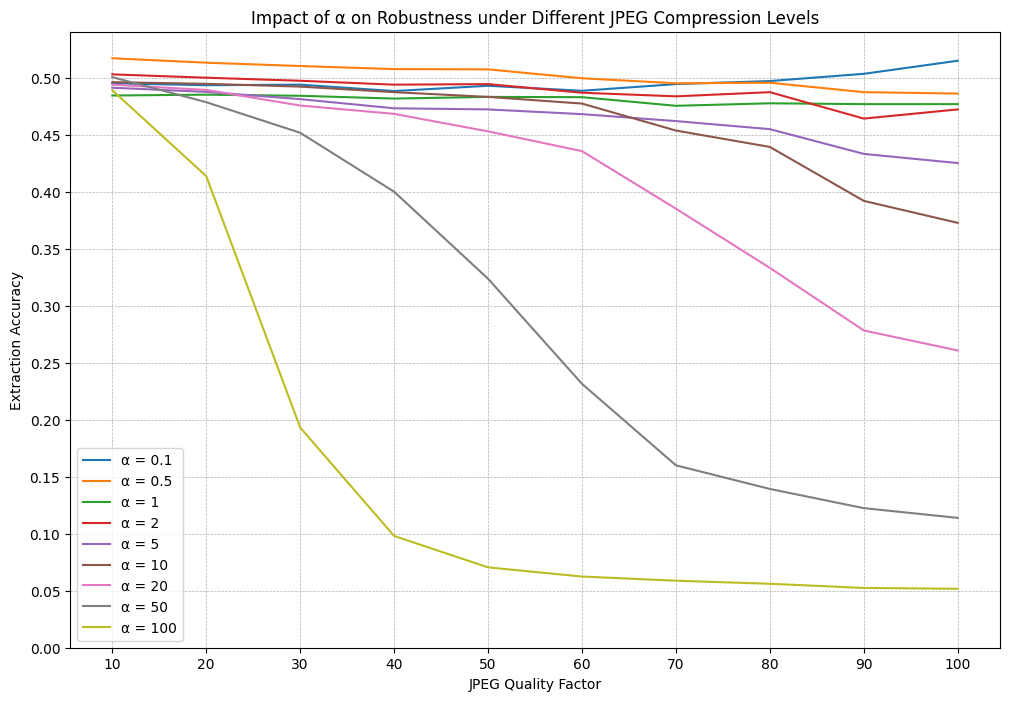

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 8))
for alpha in alpha_values:
    qfs, accuracies = zip(*results[alpha])
    ax.plot(qfs, accuracies, label=f'α = {alpha}')
    
ax.set_xlabel('JPEG Quality Factor')
ax.set_ylabel('Extraction Accuracy')
ax.set_title('Impact of α on Robustness under Different JPEG Compression Levels')
ax.legend()

ax.set_xticks(range(10, 110, 10))
ax.set_yticks(np.linspace(0, 0.5, 11))

# ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # 在每个主要刻度之间添加1个次要刻度
# ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # 在每个主要刻度之间添加1个次要刻度

ax.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.show()

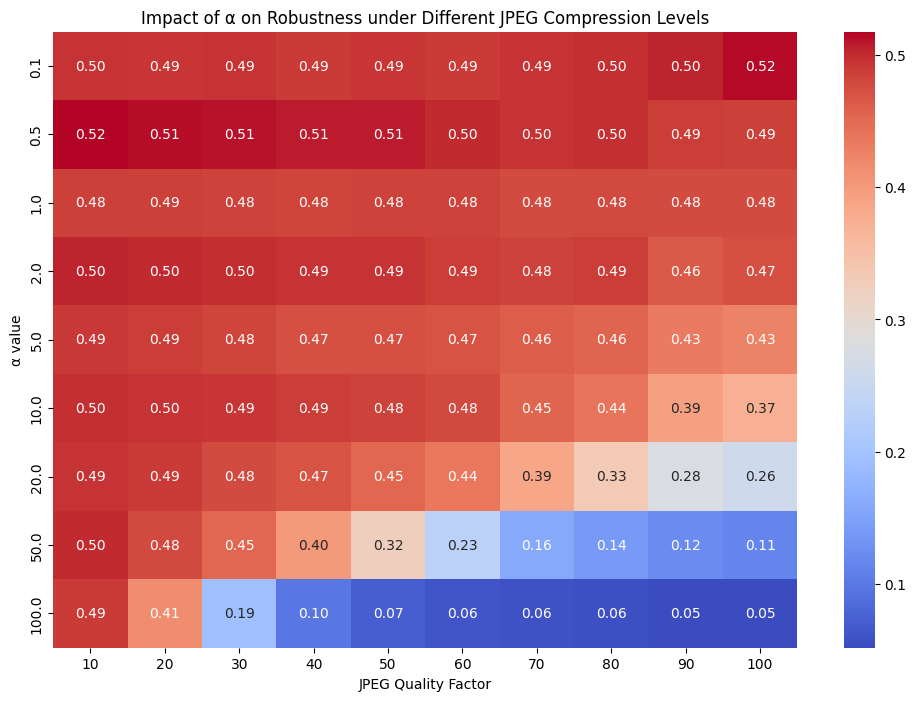

In [ ]:
# draw heatmap by seaborn
import seaborn as sns
import pandas as pd

df = pd.read_csv('results.csv')
df = df.set_index('Alpha')
plt.figure(figsize=(12, 8))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Impact of α on Robustness under Different JPEG Compression Levels')
plt.xlabel('JPEG Quality Factor')
plt.ylabel('α value')
plt.show()
